# [LAB09] 지도학습 > 분류 > 06-클래스 불균형 처리

## #01. 준비작업

### [1] 패키지 가져오기

In [7]:
# 라이브러리 기본 참조
from hossam import *
from pandas import DataFrame, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler

# 분류모형
from sklearn.ensemble import RandomForestClassifier

# 클래스 불균형 해결 라이브러리
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 클래스 불균형 해결이 필요한 경우 imblearn의 Pipeline을 사용하여
# 오버샘플링과 언더샘플링을 포함한 파이프라인을 구축할 수 있다.
from imblearn.pipeline import Pipeline as imbPipeline

import sys

sys.path.append("/Users/jinwoo/Machine_Learning")
from hs_eval_utils import *

### [2] 앞서 정의한 함수

함수 사용에 필요한 import문은 [1]에서 생략되었습니다.

- hs_cls_bin_scores

### [3] 데이터 가져오기

In [8]:
origin = load_data("pima_indians_diabetes_preprocessed")
origin.head()

캐글에서 제공하는 pima_indians_diabetes의 전처리 완료 버전(결측치 정제+로그변환) (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.946,5.004,72,3.584,4.836,3.544,0.487,3.932,1
1,0.693,4.454,66,3.401,4.836,3.318,0.301,3.466,0
2,2.197,5.215,64,3.401,4.836,3.190,0.514,3.497,1
3,0.693,4.500,66,3.178,4.554,3.371,0.154,3.091,0
4,0.000,4.927,40,3.584,5.130,3.786,1.190,3.526,1


### [4] 훈련,검증 데이터 분리

In [9]:
df = origin.copy()

# 중요!!! 종속변수를 정수형으로 변환해야 한다.
df["Outcome"] = df["Outcome"].astype("int")

yname = "Outcome"
x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #02. RandomForest 분류 모형 적합

비교를 위해 순정 형태로 구성

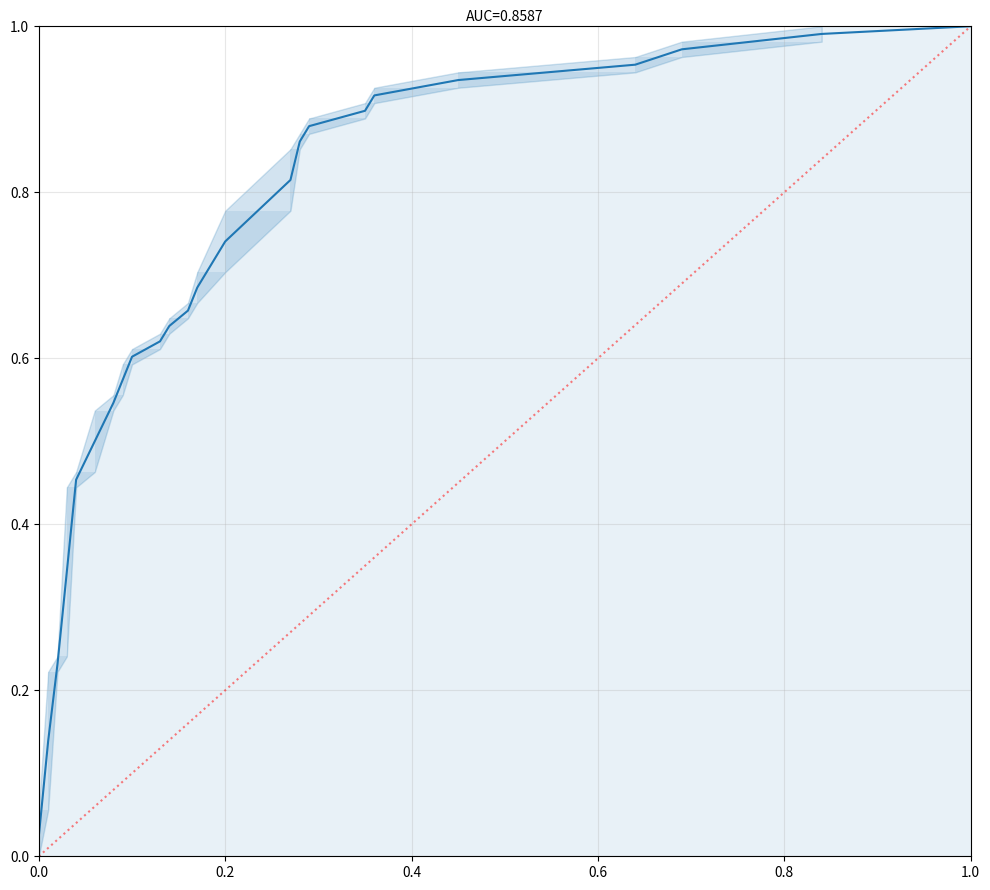

CPU times: user 1.69 s, sys: 166 ms, total: 1.86 s
Wall time: 16.3 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
RandomForestClassifier,0.747,0.609,0.778,0.270,0.730,0.683,0.859


In [10]:
%%time

rf_cls_pipe = Pipeline([
    (
        "model",
        RandomForestClassifier(
            random_state=52,
            n_jobs=-1
        )
    ),
])

rf_cls_param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 10],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": ["sqrt", 1.0],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [None, "balanced"],
}

rf_cls_gs = GridSearchCV(
    estimator=rf_cls_pipe,
    param_grid=rf_cls_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

rf_cls_gs.fit(x_train, y_train)

rf_cls_estimator = rf_cls_gs.best_estimator_

rf_cls_score_df = hs_cls_bin_scores(
    rf_cls_estimator,
    x_test,
    y_test
)
rf_cls_score_df

## #03. 데이터 불균형의 이해

### [1] 종속변수 비율

In [11]:
origin["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

### [2] 데이터 불균형(Class Imbalance)이란?

분류 문제에서 종속변수(타깃)의 클래스 비율이 크게 차이 나는 상태

#### 데이터 불균형 상황

- 한 클래스가 압도적으로 많음
- 다른 클래스는 매우 적음
- 모델이 특정 클래스에 편향될 위험 존재

#### 데이터 불균형시 문제점

- Accuracy가 왜곡됨
  - 예: 95%가 0인 경우
  - 모두 0으로 예측해도 Accuracy = 95%
- 소수 클래스 Recall 급감

#### 데이터 불균형이 문제가 되는 사례

- 사기탐지
- 질병진단
- 고장탐지
- 고객 이탈 예측

## #04. 데이터 불균형의 해결

> 스케일링 → 불균형 처리 → 학습

불균형 해소 처리가 포함될 경우 트리 계열이더라도 스케일링 필수

### [1] Random Under Sampling

다수 클래스 일부 제거

- 학습속도 빠름
- 예측 성능 감소

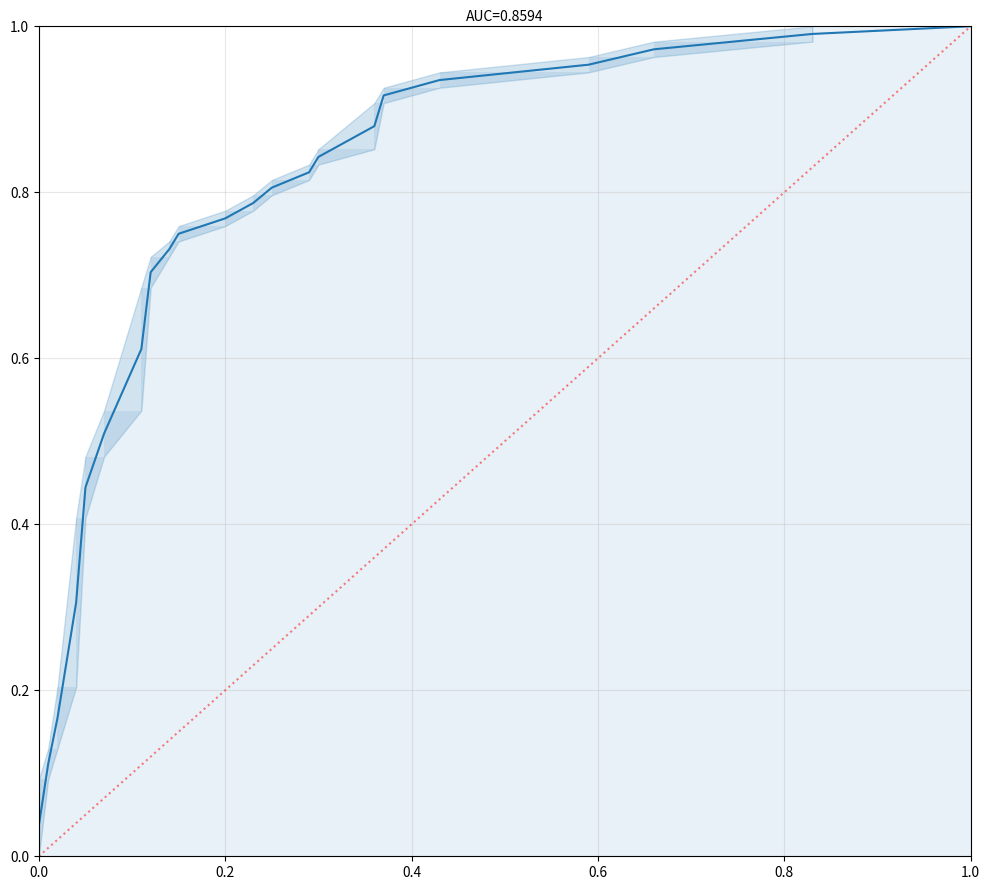

,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
기본,0.747,0.609,0.778,0.270,0.730,0.683,0.859
언더샘플링,0.760,0.620,0.815,0.270,0.730,0.704,0.859


In [12]:
rus_pipe = imbPipeline(
    [
        ("scaler", StandardScaler()),
        ("rus", RandomUnderSampler(random_state=52)),
        ("model", RandomForestClassifier(random_state=52, n_jobs=-1)),
    ]
)

rus_param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 10],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": ["sqrt", 1.0],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [None, "balanced"],
}

rus_gs = GridSearchCV(
    estimator=rus_pipe, param_grid=rus_param_grid, cv=5, scoring="roc_auc", n_jobs=-1
)

rus_gs.fit(x_train, y_train)

rf_cls_estimator = rus_gs.best_estimator_

rus_score_df = hs_cls_bin_scores(rf_cls_estimator, x_test, y_test)

rdf = concat([rf_cls_score_df, rus_score_df], axis=0)
rdf.index = ["기본", "언더샘플링"]
rdf

### [2] Random Over Sampling

- 소수 클래스 데이터를 무작위 복제
  - 데이터 중복 발생
  - 과적합 위험 높음
- 단순한 방식

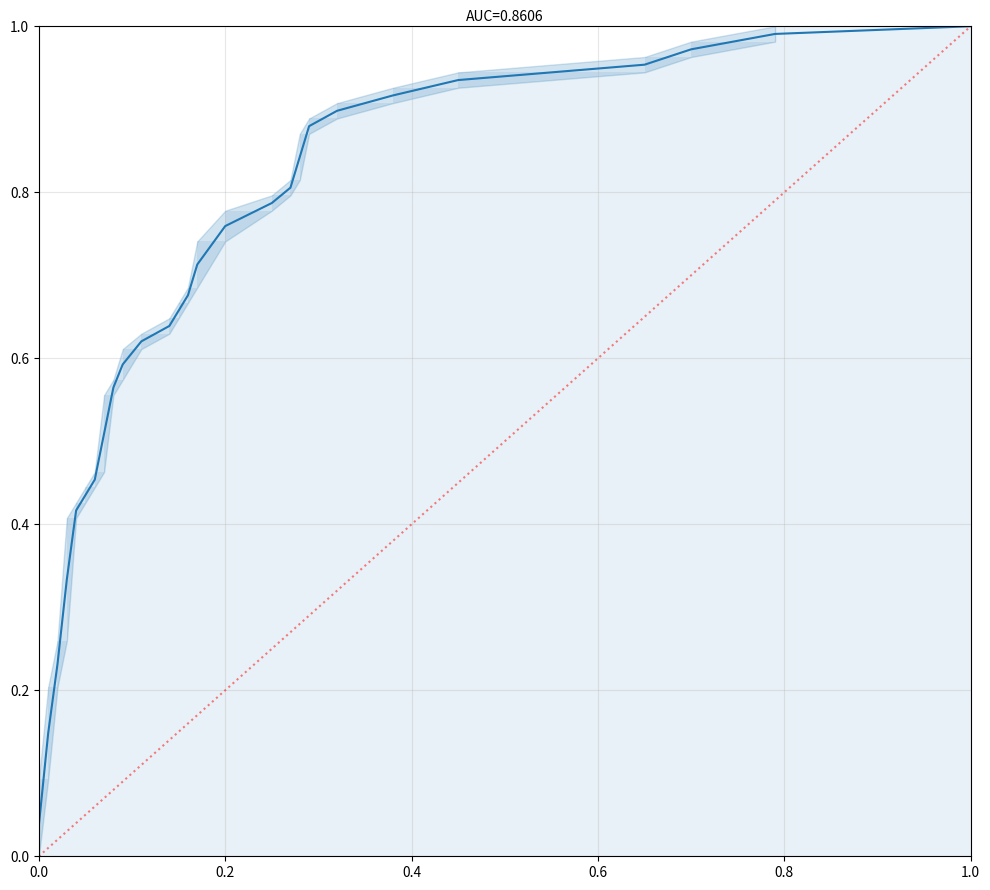

,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
기본,0.747,0.609,0.778,0.270,0.730,0.683,0.859
언더샘플링,0.760,0.620,0.815,0.270,0.730,0.704,0.859
오버샘플링,0.760,0.620,0.815,0.270,0.730,0.704,0.861


In [13]:
ros_pipe = imbPipeline(
    [
        ("scaler", StandardScaler()),
        ("ros", RandomOverSampler(random_state=52)),
        ("model", RandomForestClassifier(random_state=52, n_jobs=-1)),
    ]
)

ros_param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 10],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": ["sqrt", 1.0],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [None, "balanced"],
}

ros_gs = GridSearchCV(
    estimator=ros_pipe, param_grid=ros_param_grid, cv=5, scoring="roc_auc", n_jobs=-1
)

ros_gs.fit(x_train, y_train)

rf_cls_estimator = ros_gs.best_estimator_

ros_score_df = hs_cls_bin_scores(rf_cls_estimator, x_test, y_test)

rdf = concat([rf_cls_score_df, rus_score_df, ros_score_df], axis=0)
rdf.index = ["기본", "언더샘플링", "오버샘플링"]
rdf

### [3] SMOTE

- 최근접 이웃(knn) 기반 가상 샘플 생성
- 단순 복제가 아니라 보간(interpolation) 수행
- 가장 기본적인 데이터 증강 방법

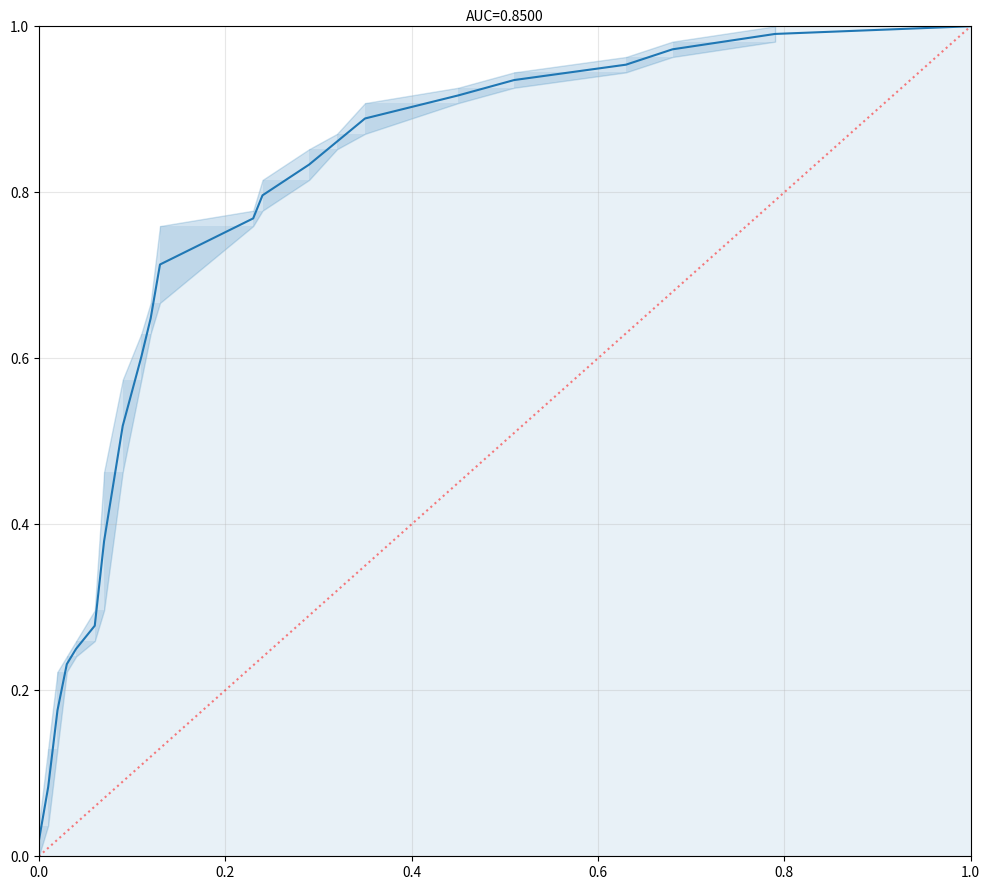

,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
기본,0.747,0.609,0.778,0.270,0.730,0.683,0.859
언더샘플링,0.760,0.620,0.815,0.270,0.730,0.704,0.859
오버샘플링,0.760,0.620,0.815,0.270,0.730,0.704,0.861
SMOTE,0.766,0.629,0.815,0.260,0.740,0.710,0.850


In [14]:
sm_pipe = imbPipeline(
    [
        ("scaler", StandardScaler()),
        ("sm", SMOTE(random_state=52, k_neighbors=5)),
        ("model", RandomForestClassifier(random_state=52, n_jobs=-1)),
    ]
)

sm_param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 10],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": ["sqrt", 1.0],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [None, "balanced"],
}

sm_gs = GridSearchCV(
    estimator=sm_pipe, param_grid=sm_param_grid, cv=5, scoring="roc_auc", n_jobs=-1
)

sm_gs.fit(x_train, y_train)

rf_cls_estimator = sm_gs.best_estimator_

sm_score_df = hs_cls_bin_scores(rf_cls_estimator, x_test, y_test)

rdf = concat([rf_cls_score_df, rus_score_df, ros_score_df, sm_score_df], axis=0)
rdf.index = ["기본", "언더샘플링", "오버샘플링", "SMOTE"]
rdf